# Plot matern correlation lengths

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
from xmitgcm import open_mdsdataset,utils
from xgcm import Grid
import ecco_v4_py

import pych.ecco as pe

from matern import MaternField

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = SLURMCluster()
cluster.adapt(minimum=0, maximum=10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.1.1.4:8787/status,
Dashboard: http://10.1.1.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.1.4:46425,Workers: 0
Dashboard: http://10.1.1.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
plt.style.use('thesis')

In [6]:
xi = 1

In [10]:
def readme(n_range, drop_coords=True):
    ds = xr.open_zarr(f'/scratch2/tsmith/generic-matern-covariance/sampling/llc90/sample-3D-C/zstores/matern.{n_range:02d}dx.{xi:02}xi.zarr',
                      chunks={'k':50})
    ds = ds.isel(sample=slice(100))
    
    with xr.set_options(keep_attrs=True):
        
        ds['variance'] = 1/ds['smooth3Dnorm001']**2
        ds['sigma'] = 1/ds['smooth3Dnorm001']
        ds['ginv_norm'] = (ds['smooth3Dfld001'] * ds['smooth3Dnorm001'] ).where(ds.maskC)
        
        ds['variance'].attrs = {'label':r'$\hat{\sigma}^2$'}
        ds['sigma'].attrs = {'label':r'$\hat{\sigma}$'}
        ds['smooth3Dmean001'] = ds['smooth3Dfld001'].mean('sample')
    
    if drop_coords:
        ds = ds.reset_coords(drop=True)
    return ds

In [11]:
all_ranges = [5,10,15,20]
dsd = {n_range: readme(n_range) for n_range in all_ranges}

# Get a single grid dataset and drop the others
grid = readme(5, drop_coords=False).coords.to_dataset()

In [13]:
# lets get this party started

for xds in dsd.values():
    for key in ['ginv_norm', 'smooth3Dmean001']:
        xds[key] = xds[key].persist()
grid['maskC'] = grid['maskC'].persist()

### Correlation lengths

In [14]:
import dask.array as darray

In [15]:
def calc_correlation_field(xda, mask, sample_mean,
                           dimlist=('k',),
                           n_shift=15):
    xds = xr.Dataset()
    shifty = np.arange(-n_shift,n_shift+1)
    shifty = xr.DataArray(shifty,coords={'shifty':shifty},dims=('shifty',))
    xds['shifty'] = shifty
    
    # Do this part once
    x_deviation = (xda.data - sample_mean.data[None]).persist()
    x_ssr_inv = (1/np.sqrt( darray.nansum(x_deviation**2, axis=0) )).persist()
    
    dim=dimlist[0]
    assert dim != 0
    
    axis = xda.dims.index(dim)
    
    avg_corr = []
    std_corr = []
    for s in shifty.values:
        avg,std = _calc_shifted(x_deviation, x_ssr_inv, int(s), axis)
        avg_corr.append(avg)
        std_corr.append(std)
        
    # Package it up
    coords = {'shifty':shifty, dim:xda[dim]}
    dims = tuple(coords.keys())
    avg_corr = xr.DataArray(darray.stack(avg_corr, axis=0).persist(),
                            coords=coords,
                            dims=dims)
                            
    std_corr = xr.DataArray(darray.stack(std_corr, axis=0).persist(),
                            coords=coords,
                            dims=dims)
    return avg_corr, std_corr

def _calc_shifted(xdev, xssrinv, n_shift, axis):
    
    y_deviation = _shift(xdev, axis=axis, n_shift=n_shift)
    numerator = darray.nansum(xdev*y_deviation, axis=0)
    y_ssr = np.sqrt( darray.nansum(y_deviation**2, axis=0))
    full_field = numerator / y_ssr * xssrinv
    
    sum_dims = tuple(x for x in range(xdev.ndim-1) if x != axis-1)
    avg = darray.nanmean(full_field, axis=sum_dims)
    std = darray.nanstd(full_field, axis=sum_dims)
    return avg, std

def _shift(array, axis, n_shift, fill_value=np.nan):
    result = darray.roll(array, n_shift, axis=axis)
    result = result.rechunk({axis:None})
    if n_shift>=0:
        result[:n_shift] = fill_value
    else:
        result[n_shift:] = fill_value
    return result

def _print(name, array):
    print(f"{name}")
    print(f"\t{array.shape}")
    print(f"\t{array.chunksize}")
    print()
    return

In [16]:
# Compute approximate correlation

for n_range, xds in dsd.items():
    avg, std = calc_correlation_field(xds['ginv_norm'],
                                      mask=grid['maskC'],
                                      sample_mean=xds['smooth3Dmean001'],
                                      dimlist=('k',),
                                      n_shift=2*xi*n_range)
    
    xds['avg_corr_k'] = avg
    xds['std_corr_k'] = std

    # Compute prediction
    mf = MaternField(grid['maskC'], n_range=n_range, horizontal_factor=xi)
    xds['delta_khat'] = np.abs(xds['shifty'])
    xds['ideal_corr_k'] = mf.ideal_correlation(distance=xds['delta_khat'])

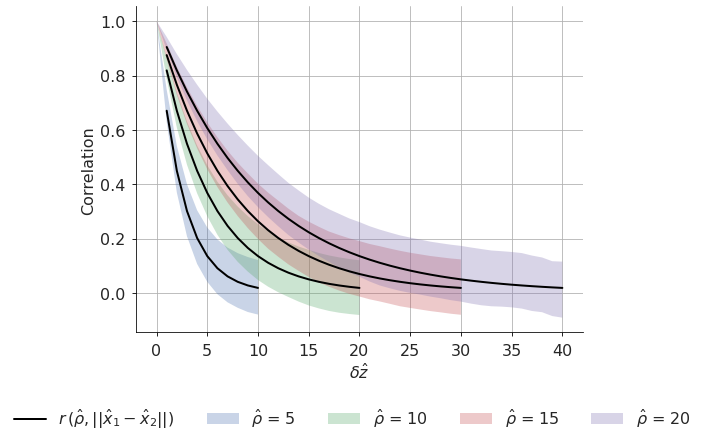

In [29]:
kk = 9
dim='k'

ncols = 1
nrows = 1

fig,ax = plt.subplots(nrows,ncols,figsize=(8,6*nrows),
                       sharey=True)

for n_range, xds in dsd.items():
    
    theory_label = r'$r\,(\hat{\rho},||\hat{x}_1-\hat{x}_2||)$' if n_range == 5 else None
    exp_label=r'$\hat{\rho}$ = %d' % n_range
    
    for condition in [xds['shifty']<=0]:#, xds['shifty']<=0]:
        
        x = xds[f'delta_{dim}hat'].where(condition)
        #condition = condition & (x<25)
        theory = xds[f'ideal_corr_{dim}'].where(condition)
        yavg = xds[f"avg_corr_{dim}"].sel(k=kk).where(condition)
        ystd = xds[f"std_corr_{dim}"].sel(k=kk).where(condition)
        
        ax.plot(x, theory, label=theory_label, color='black')
        #ax.plot(x, yavg, marker='o')
        ax.fill_between(x,yavg-ystd, yavg+ystd,
                        alpha=.3,
                        label=exp_label)

ax.set(xlabel=r'$\delta\hat{z}$',ylabel='',title='')
ax.set_ylabel('Correlation')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
        
#fig.subplots_adjust(wspace=.05)
fig.legend(ncol=5,
           loc='center',
           bbox_to_anchor=(.5,-0.075),
           frameon=False)
fig.savefig(f'{fig_dir}/llc90_nondimensional_correlation_k.pdf',bbox_inches='tight')

### Plotting note

Need to generalize the cutoff based on `k`

### A note about the inaccuracy/locality of Jacobians... 
Here I'm truly considering the distance to be the number of neighboring grid cells.
I went through the whole process of using the Jacobian to approximate distances in ideal space, but this is
not really accurate.
Really we want the comparison to be in "grid cell space", and that's what we get.
I would consider grid cell space to be:
$$\varphi(\mathbf{x}_1) - \varphi(\mathbf{x}_2)$$
and
$$\Phi|_{\mathbf{x}_{1}} (\mathbf{x}_1 - \mathbf{x}_2)$$
is not a good approximation of this for distances that matter.
Even 3-5 grid cells away it starts to be a pretty bad approximation

## Some initial plots of samples

In [ ]:
dsd[5].smooth3Dfld001.where(grid.maskC).isel(face=4,sample=0,j=50).plot(yincrease=False)